In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import time

#Home folder
Home = 'C:\\Users/DELL/Python.Practice/Data Analysis/Part2/Simulation/'

#GEOMEGA file path
GeoFile = Home+'Scintillator1215_Tan.geo.setup'
print ('GeoFile:', GeoFile)

#Simulation Data
Folder = 'Isotropic/'
GammaEnergy = [60, 122, 511, 662, 1173, 1275, 1333]
Prefix = 'GammaMono_'
Endfix = 'keV.inc1.id1.sim'
# SimFile = Prefix + GammaEnergy[i] + Endfix

Plastic_Threshold = 0
Crystal_Threshold = 0

GeoFile: C:\Users/DELL/Python.Practice/Data Analysis/Part2/Simulation/Scintillator1215_Tan.geo.setup


In [2]:
def ReadData(file):
    # READ DATA FILE
    with open(file, 'r') as fp:
        lines = []
        for line in fp:
            lines.append(line[:-1]) if line[-1] == "\n" else lines.append(line)
            #print (lines)
    return lines
print ('Done!')

Done!


## Scan the GEOMEGA file and find the geometry volume

In [3]:
#Define a function to scan the file and find the geometry volume
def FindVolume(GeoFile):
  #Read the GEOMEGA file
    geo = ReadData(GeoFile)
    print ('-----------------------------------------------\nSTART READING THE GEOMEGA\'S .GEO.SETUP FILES...')
    print ('\n Reading file:', GeoFile)
    VolumeName = []
    VolumeBRIK = [] # size of BRIK, count from the center point of each dimention. Ex. (x, y, z) = (1,2,3) means x-size = 2, y-size = 4.
    VolumeNameBRIK = []
    VolumePositionBRIK = [] # Position of BRIK (center point of BRIK in Oxyz)
    Scintillators = [] # List of Scintillator BRIK only.
    v = 0
    Shape = ''
    for i in range(len(geo)):
        #print('geo[i]\n', geo[i])
        #print('len(geo[i]):', len(geo[i]))
        if len(geo[i]) == 1 or len(geo[i]) == 0:
            # This condition is in order to avoid reading the blank line.
            #continue
            pass
        else:
          # Reading line by line, split each value as string, delimiter is the space.
            textline = geo[i].split()
            #if textline == '': #On local machine
            if len(textline) == 0: #On server
              # Skipping the blank line
                break
            if textline[0] == 'Volume':
                #print '\n #',v,'Volume detected: ' + textline[1]
                #f.write('\n\n #'+str(v)+' Volume detected: ' + textline[1])
                VolumeName.append(textline[1])
                v+=1
            if textline[0] == 'Strip3D':
                Scintillator = textline[1].replace('Strip_', '')
                Scintillators.append(Scintillator)
                print (' *** Detector detected: ', Scintillator)
            for j in range(len(VolumeName)):
                # Finding matched string in a volume: Shape, BRIK, Position...
                if textline[0] == VolumeName[j]+'.Shape' and textline[1] == 'BRIK':
                    #print ' BRIK shape detected: ' + textline[2] +', '+ textline[3] +', '+ textline[4]
                    #f.write('\n BRIK shape detected: ' + textline[2] +', '+ textline[3] +', '+ textline[4])
                    VolumeBRIK.append([textline[2], textline[3], textline[4]])
                    Shape = textline[1]
                    VolumeNameBRIK.append(VolumeName[j])
                if textline[0] == VolumeName[j]+'.Position' and Shape == 'BRIK':
                    #print ' Volume\'s Position: ' + textline[1] +', '+ textline[2] +', '+ textline[3]
                    #f.write('\n Volume\'s Position: ' + textline[1] +', '+ textline[2] +', '+ textline[3])
                    VolumePositionBRIK.append([textline[1], textline[2], textline[3]])


    # Convert list into array
    VolumeBRIK = np.asarray(VolumeBRIK)
    VolumePositionBRIK = np.asarray(VolumePositionBRIK)

    # print ('VolumeBRIK = ', VolumeBRIK)
    X, Y, Z, X_Scin, Y_Scin, Z_Scin = [], [], [], [], [], []
    for i in range(len(VolumeBRIK)-1):
        # GENERATE THE BOX SHAPE
        x, y, z = float(VolumeBRIK[i+1][0]), float(VolumeBRIK[i+1][1]), float(VolumeBRIK[i+1][2]) # Size of BRIK.
        Ox, Oy, Oz = float(VolumePositionBRIK[i+1][0]), float(VolumePositionBRIK[i+1][1]), float(VolumePositionBRIK[i+1][2]) # position of center point of BRIK.
        x1, x2, x3, x4, x5, x6, x7, x8 = Ox+x, Ox+x, Ox+x, Ox+x, Ox-x, Ox-x, Ox-x, Ox-x # 8 corner point of the box.
        y1, y2, y3, y4, y5, y6, y7, y8 = Oy+y, Oy-y, Oy-y, Oy+y, Oy+y, Oy-y, Oy-y, Oy+y
        z1, z2, z3, z4, z5, z6, z7, z8 = Oz+z, Oz+z, Oz-z, Oz-z, Oz+z, Oz+z, Oz-z, Oz-z

        # Position of the corner points of the box
        XX = [x1, x2, x3, x4, x5, x6, x7, x8]
        YY = [y1, y2, y3, y4, y5, y6, y7, y8]
        ZZ = [z1, z2, z3, z4, z5, z6, z7, z8]

        X += [XX]
        Y += [YY]
        Z += [ZZ]
        for j in range(len(Scintillators)):
            if Scintillators[j] == VolumeNameBRIK[i+1]:
                X_Scin += [XX]
                Y_Scin += [YY]
                Z_Scin += [ZZ]
    X, Y, Z = [], [], []
    print ('-----------------------------------------------\n There are', len(X_Scin), 'Detectors in this GeoMega file!')
    for i in range(len(X_Scin)): # Get the min and max edges of each BRIK
        X += [[min(X_Scin[i]), max(X_Scin[i])]]
        Y += [[min(Y_Scin[i]), max(Y_Scin[i])]]
        Z += [[min(Z_Scin[i]), max(Z_Scin[i])]]
        print (' \n #', i+1, Scintillators[i])
        print ('\tX(min, max) = \t(', min(X_Scin[i]), ', ', max(X_Scin[i]), ')')
        print ('\tY(min, max) = \t(', min(Y_Scin[i]), ', ', max(Y_Scin[i]), ')')
        print ('\tZ(min, max) = \t(', min(Z_Scin[i]), ', ', max(Z_Scin[i]), ')')
    #print VolumeBRIK
    print ('\nDone!')
    print ('\nGeoMega file reading is finished!')
    #f.write('\n\n GeoMega file reading is finished!')
    #f.close()
    return Scintillators, X, Y, Z

print ('Function has been created!')

Function has been created!


In [4]:
# Run the function
Scintillators, X, Y, Z = FindVolume(GeoFile)

-----------------------------------------------
START READING THE GEOMEGA'S .GEO.SETUP FILES...

 Reading file: C:\Users/DELL/Python.Practice/Data Analysis/Part2/Simulation/Scintillator1215_Tan.geo.setup
 *** Detector detected:  Vol_Scin_Crystal
 *** Detector detected:  Vol_Scin_Plastic_1
 *** Detector detected:  Vol_Scin_Plastic_2
 *** Detector detected:  Vol_Scin_Plastic_3
 *** Detector detected:  Vol_Scin_Plastic_4
 *** Detector detected:  Vol_Scin_Plastic_5
-----------------------------------------------
 There are 6 Detectors in this GeoMega file!
 
 # 1 Vol_Scin_Crystal
	X(min, max) = 	( -0.6 ,  0.6 )
	Y(min, max) = 	( -0.6 ,  0.6 )
	Z(min, max) = 	( 0.20000000000000007 ,  1.4 )
 
 # 2 Vol_Scin_Plastic_1
	X(min, max) = 	( -2.55 ,  -1.05 )
	Y(min, max) = 	( -2.55 ,  1.05 )
	Z(min, max) = 	( 0.0 ,  3.08 )
 
 # 3 Vol_Scin_Plastic_2
	X(min, max) = 	( 1.05 ,  2.55 )
	Y(min, max) = 	( -1.05 ,  2.55 )
	Z(min, max) = 	( 0.0 ,  3.08 )
 
 # 4 Vol_Scin_Plastic_3
	X(min, max) = 	( -2.55 ,  1

# Read the COSIMA simulation files

## Read the HTsim data

In [5]:
#Create a function to read the HTsim data from COSIMA files
def Read_HTsim(SimFile, X, Y, Z, Plastic_Threshold, Crystal_Threshold, ED_HTsim_Detector):
    start1 = time.time()
  
    Current_Event_HT = [0,0,0,0,0,0,0] # [ID, C, P1, P2, P3, P4, P5]
    ED_Detector_HT = []
    ID = 0
    k = 0
    #Start reading SimFile
    with open(SimFile) as fileobject:
        for line in fileobject:
            if len(line) == 1:
                continue
            else:
                # Reading line by line, split each value as string, delimiter is the space.
                textline = line.replace(';',' ').replace(',',' ').split()
            #print textline
            if textline == []:
                # Skipping the blank line
                continue
            if textline[0] == 'ID' or textline[0] == 'TE': #Write the temporary data from previous event
                if textline[0] == 'ID':
                    ID = int(textline[1]) #ID of the event
                if ID > 0:
                    if ID%1000==0:
                        k+=1
                        print (' + ', k*1000, ' events have been read!')
                    if len(ED_Detector_HT) >1:
                        if ED_Detector_HT[1] <= Crystal_Threshold:
                            ED_Detector_HT[1] = 0
                        for i in range(len(ED_Detector_HT)-2):
                            if ED_Detector_HT[i+2] <= Plastic_Threshold:
                                ED_Detector_HT[i+2] = 0
                    # Write HTsim data for this sequence: ID, Crystal, P1, P2, P3, P4, P5
                    ED_HTsim = open(ED_HTsim_Detector, 'a')
                    if ID > 1:
                        ED_HTsim.write('\n')
                    for i in range(len(ED_Detector_HT)):
                        ED_HTsim.write('\t'+str(ED_Detector_HT[i])+'\t')
                    ED_HTsim.close()
                    ED_Detector_HT = []
                    Current_Event_HT = [0,0,0,0,0,0,0]
                #End of file
                if textline[0] == 'TE':
                    print ('\n    ID at TE:', ID)
                    print ('   ', line)
                    print ('   End of the data file.')
                    ED_HTsim = open(ED_HTsim_Detector, 'a')
                    ED_HTsim.write('\n# End')
                    ED_HTsim.close()
            if textline[0] == 'HTsim':
                Current_Event_HT = [0,0,0,0,0,0,0]
                for j in range(len(X)): # Separate interactions by detectors
                    #for j in range(NumberOfDetectors): #Only use for 6 detectors (6 first volume)
                    if float(textline[2]) >= X[j][0] and float(textline[2]) <= X[j][1] and float(textline[3]) >= Y[j][0] and float(textline[3]) <= Y[j][1] and float(textline[4]) >= Z[j][0] and float(textline[4]) <= Z[j][1]: # Compare the position of each interactions with the min and max edges of the BRIKs
                        Current_Event_HT[j+1] += float(textline[5])
                #print ('Current_Event_HT = ', len(Current_Event_HT), Current_Event_HT)
                if len(ED_Detector_HT) == 0:
                    ED_Detector_HT = Current_Event_HT
                else:  
                    ED_Detector_HT = np.add(ED_Detector_HT, Current_Event_HT)
            if len(ED_Detector_HT) == 7:
                ED_Detector_HT[0] = ID
        #print ('ED_Detector_HT = ', len(ED_Detector_HT), ED_Detector_HT)
print ('Function has been created!')

Function has been created!


In [6]:
for i in range(len(GammaEnergy)):
    #print i
    Energy = int(GammaEnergy[i])
    SimFile = Home + Folder + Prefix + str(Energy) + Endfix
    print ('\n Reading sim file: '+Prefix+str(Energy)+Endfix)
    # Record HTsim data to ED_HTsim file: ID, Crystal, P1, P2, P3, P4, P5
    ED_HTsim_Detector = Home+Folder+'Data/_HTsim_Detectors_'+str(Energy)+'.txt'
    ED_HTsim = open(ED_HTsim_Detector, 'w+')
    ED_HTsim.write('# File: '+str(ED_HTsim_Detector))
    ED_HTsim.write('\n# Created on '+str(time.ctime()))
    ED_HTsim.write('\n# GeoFile: '+GeoFile)
    ED_HTsim.write('\n# SimFile: '+SimFile)
    ED_HTsim.write('\n# Plastic threshold: '+str(Plastic_Threshold))
    ED_HTsim.write('\n# Crystal threshold: '+str(Crystal_Threshold))
    ED_HTsim.write('\n#\n#\tID\t\tCrystal\t\tP1\t\tP2\t\tP3\t\tP4\t\tP5\n#')
    ED_HTsim.close()
    #Start to read the COSIMA file
    Read_HTsim(SimFile, X, Y, Z, Plastic_Threshold, Crystal_Threshold, ED_HTsim_Detector)
    print ('\n-------------------------------------------------\n')


 Reading sim file: GammaMono_60keV.inc1.id1.sim
 +  1000  events have been read!
 +  2000  events have been read!
 +  3000  events have been read!
 +  4000  events have been read!
 +  5000  events have been read!
 +  6000  events have been read!
 +  7000  events have been read!
 +  8000  events have been read!
 +  9000  events have been read!
 +  10000  events have been read!
 +  11000  events have been read!

    ID at TE: 10000
    TE 0.00495338

   End of the data file.

-------------------------------------------------


 Reading sim file: GammaMono_122keV.inc1.id1.sim
 +  1000  events have been read!
 +  2000  events have been read!
 +  3000  events have been read!
 +  4000  events have been read!
 +  5000  events have been read!
 +  6000  events have been read!
 +  7000  events have been read!
 +  8000  events have been read!
 +  9000  events have been read!
 +  10000  events have been read!
 +  11000  events have been read!

    ID at TE: 10000
    TE 0.00535301

   End of the 

## Plot the histogram

In [7]:
def EnergyPlot(Energy, HTsim, DetectorName):
    plt.clf()
    plt.xlim((0,Energy+Energy/10))
    label=str(Energy)+' keV'
    plt.hist(HTsim[HTsim>0], bins=Energy, label=label)
    # plt.hist(HTsim[HTsim>0], bins=Energy//8, label=label)
    plt.title('Deposited Energy in the '+DetectorName)
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(Home+Folder+'Figures/'+'_HTsim_Detector_'+str(Energy)+'_'+DetectorName+'.png', facecolor ='w', dpi=600)
    plt.show()

print ('Function has been created!')

Function has been created!



 Reading HTsim file: Data/_HTsim_Detectors_60.txt


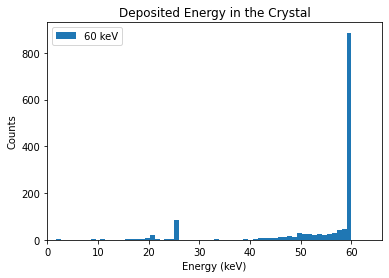

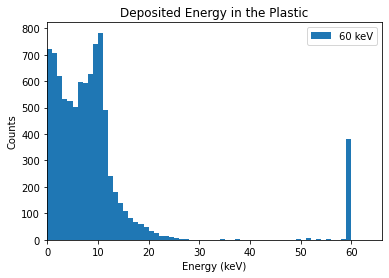

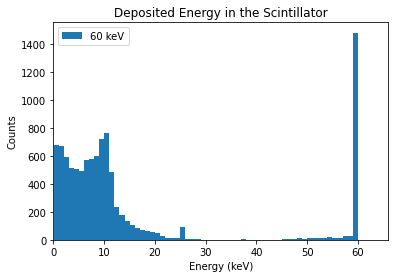


 Reading HTsim file: Data/_HTsim_Detectors_122.txt


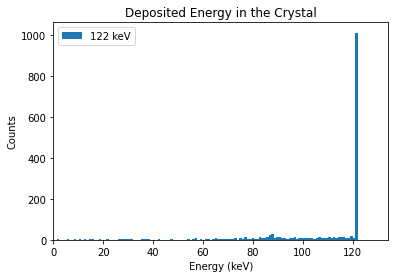

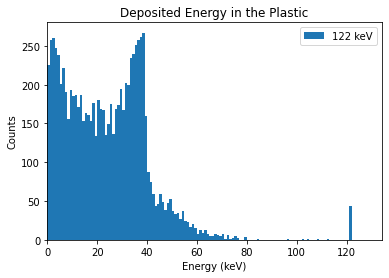

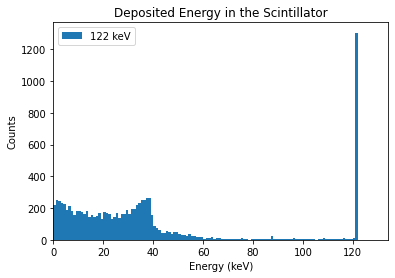


 Reading HTsim file: Data/_HTsim_Detectors_511.txt


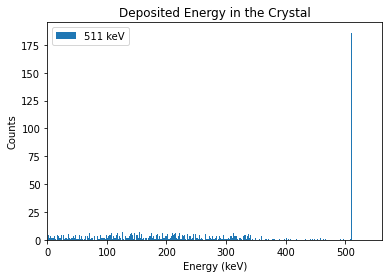

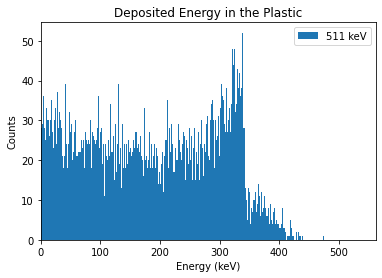

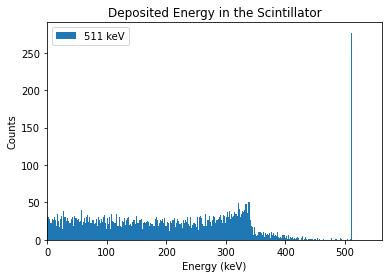


 Reading HTsim file: Data/_HTsim_Detectors_662.txt


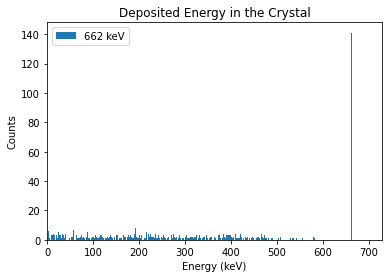

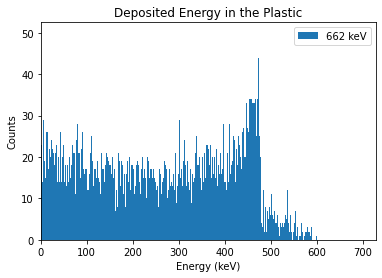

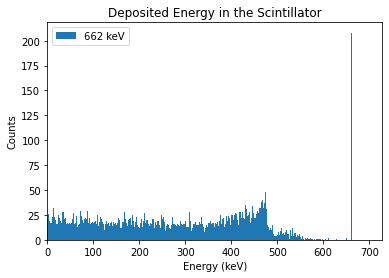


 Reading HTsim file: Data/_HTsim_Detectors_1173.txt


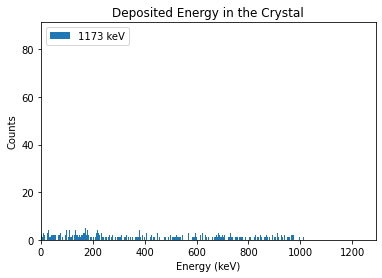

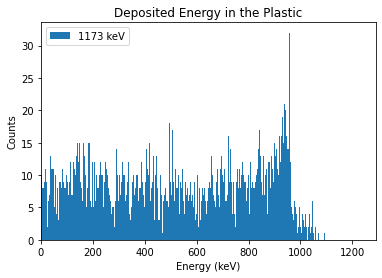

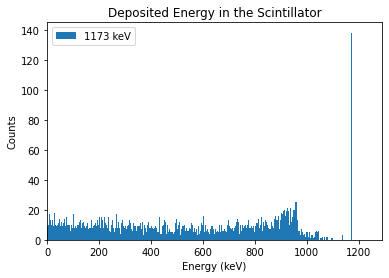


 Reading HTsim file: Data/_HTsim_Detectors_1275.txt


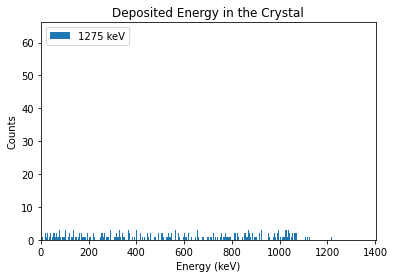

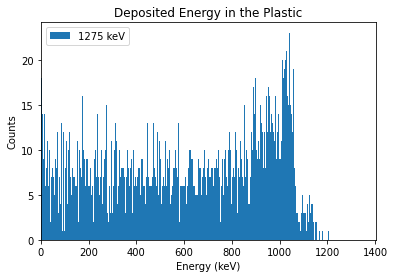

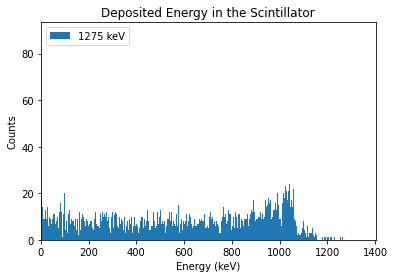


 Reading HTsim file: Data/_HTsim_Detectors_1333.txt


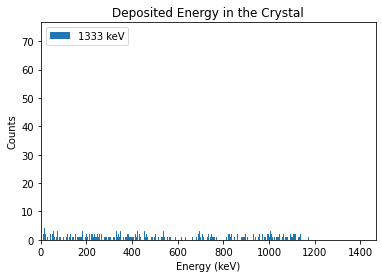

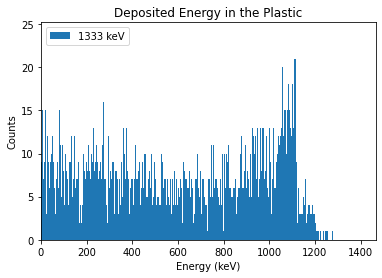

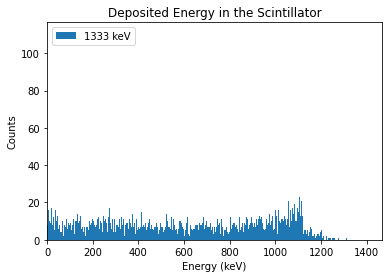

Finished!


In [8]:
for i in range(len(GammaEnergy)):
    #print i
    Energy = int(GammaEnergy[i])
    ED_HTsim_Detector = Home+Folder+'Data/_HTsim_Detectors_'+str(Energy)+'.txt'
    print ('\n Reading HTsim file: '+'Data/_HTsim_Detectors_'+str(Energy)+'.txt')
    #Read data form txt file
    HTsim = np.loadtxt(ED_HTsim_Detector, unpack=True)
    #print (len(HTsim), len(HTsim[1]), HTsim[1, :]) 
    #Energy deposited in Crystal scintillator
    DetectorName = 'Crystal'
    Crystal = HTsim[1, :]
    EnergyPlot(Energy, Crystal, DetectorName)

    #Energy deposited in Plastic scintillator
    DetectorName = 'Plastic'
    Plastic = np.asarray([HTsim[2, :], HTsim[3, :], HTsim[4, :], HTsim[5, :], HTsim[6, :]]).sum(axis = 0)
    EnergyPlot(Energy, Plastic, DetectorName)

    #Energy deposited in Both Crystal and Plastic scintillator
    DetectorName = 'Scintillator'
    Scintillator = np.asarray([HTsim[1, :], HTsim[2, :], HTsim[3, :], HTsim[4, :], HTsim[5, :], HTsim[6, :]]).sum(axis = 0)
    EnergyPlot(Energy, Scintillator, DetectorName)
print ('Finished!')